In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import math
import sklearn
import itertools

from sklearn.utils import resample
from sklearn.neighbors import NearestNeighbors

In [5]:
Data = pd.read_csv('House_Price_Regression.csv')

Data = Data.loc[:, ['latitude', 'longitude', 'price', 'size_in_m_2', 'balcony_recode', 'private_garden_recode', 'quality_recode']]

Data.head()

,latitude,longitude,price,size_in_m_2,balcony_recode,private_garden_recode,quality_recode
0,25.113208,55.138932,2700000,100.242337,1.0,0.0,2.0
1,25.106809,55.151201,2850000,146.972546,1.0,0.0,2.0
2,25.063302,55.137728,1150000,181.253753,1.0,0.0,2.0
3,25.227295,55.341761,2850000,187.664060,1.0,0.0,1.0
4,25.114275,55.139764,1729200,47.101821,0.0,0.0,2.0


In [6]:
def simple_validation_random(D, k, response, random_seed):

    # D --> have to be a pandas data frame.

    # k --> is the proportion of observation of D that define D_train.

    # response --> have to be a string with the name of the response variable.

    # random_seed --> seed to replicate the random process

    N = len(D)

    D_train = D.sample(frac=k, replace=False, random_state=random_seed)

    D_test = D.drop( D_train.index , )

    X_train = D_train.loc[: , D_train.columns != response]
    Y_train = D_train.loc[: , response]

    X_test = D_test.loc[: , D_test.columns != response]
    Y_test = D_test.loc[: , response]

############################################################################

# Training the model:

    knn_regression.fit(X_train, Y_train)

# Making predictions:

    Y_predict_test = knn_regression.predict( X_test ) 

############################################################################

    ECM_test = np.mean( (Y_predict_test - Y_test)**2 )

############################################################################

    return ECM_test

In [17]:
def repeted_random_simple_validation(D, k, B, response, random_seed):

    # D --> have to be a pandas data frame.

    # k --> is the proportion of observation of D that define D_train.

    # B --> number of replications of the random simple validation algorithm

    # response --> have to be a string with the name of the response variable.

    # random_seed --> seed to replicate the random process


    np.random.seed(random_seed)

    ECM_test_list = [ ]

    seed_array = np.random.randint(999999999, size=(1000))

    for b in range(0,B) :

        ECM_test_list.append( simple_validation_random(D, k, response, random_seed=seed_array[b]) )


    ECM_test = np.mean(ECM_test_list)    

    return ECM_test 

## Grid search con 1 hiper parametros

In [130]:
Grid_Search_Metric_list = [] 

Search_Space = range(1,100)

for k in Search_Space:

    knn_regression = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k ,  p=2, metric='minkowski')

    Grid_Search_Metric_list.append( repeted_random_simple_validation(D=Data, k=0.75, B=50, response='price', random_seed=123) )

In [131]:
df = pd.DataFrame({'k': Search_Space  , 'ECM': Grid_Search_Metric_list})

In [132]:
df.sort_values(by='ECM')

,k,ECM
16,17,2.267196e+12
17,18,2.271071e+12
15,16,2.271718e+12
12,13,2.277962e+12
14,15,2.278166e+12
...,...,...
94,95,4.118048e+12
95,96,4.128977e+12
96,97,4.138291e+12
97,98,4.149836e+12


<AxesSubplot:xlabel='k', ylabel='ECM'>

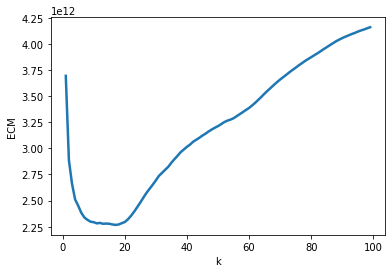

In [133]:
sns.lineplot(y=df.ECM , x=df.k, linewidth=2.5)

## Grid search con 2 hiper parametros

In [99]:
Grid_Search_Metric_list , Search_Space_1_list, Search_Space_2_list = [] , [] , []

Search_Space_1 = range(1,100)

Search_Space_2 = ['euclidean','cosine','cityblock','manhattan']

hyperparameter_combinations = list( itertools.product(space_search_1, space_search_2) )

for k in hyperparameter_combinations :

    Search_Space_1_list.append(k[0])  # n_neighbors
    Search_Space_2_list.append(k[1])  # metric

    knn_regression = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k[0] ,  metric=k[1])

    Grid_Search_Metric_list.append( repeted_random_simple_validation(D=Data, k=0.75, B=50, response='price', random_seed=123) )

In [84]:
df = pd.DataFrame({'k': Search_Space_1_list, 'Distance': Search_Space_2_list, 'ECM': Grid_Search_Metric_list})

In [86]:
df.sort_values(by='ECM')

,k,Distance,ECM
49,13,cosine,2.243728e+12
53,14,cosine,2.249664e+12
61,16,cosine,2.253979e+12
57,15,cosine,2.256147e+12
65,17,cosine,2.258436e+12
...,...,...,...
192,49,euclidean,3.197892e+12
1,1,cosine,3.643881e+12
0,1,euclidean,3.694603e+12
3,1,manhattan,3.960430e+12


## Random Grid search con 2 hiper parametros

In [ ]:
from sklearn.utils import resample

In [96]:
Grid_Search_Metric_list , Search_Space_1_list, Search_Space_2_list = [] , [] , []

Search_Space_1 = range(1,1000)

Search_Space_2 = ['euclidean','cosine','cityblock','manhattan']

hyperparameter_combinations = list( itertools.product(Search_Space_1, Search_Space_2) )

hyperparameter_combinations = resample(hyperparameter_combinations, n_samples=150, replace=False, random_state=123)

for k in hyperparameter_combinations :

    Search_Space_1_list.append(k[0])  # n_neighbors
    Search_Space_2_list.append(k[1])  # metric

    knn_regression = sklearn.neighbors.KNeighborsRegressor(n_neighbors=k[0] ,  metric=k[1])

    Grid_Search_Metric_list.append( repeted_random_simple_validation(D=Data, k=0.75, B=50, response='price', random_seed=123) )

In [97]:
df = pd.DataFrame({'k': Search_Space_1_list, 'Distance': Search_Space_2_list, 'ECM': Grid_Search_Metric_list})

In [98]:
df.sort_values(by='ECM')

,k,Distance,ECM
74,14,cosine,2.249664e+12
8,15,cosine,2.256147e+12
0,17,manhattan,2.260744e+12
56,18,manhattan,2.264480e+12
69,12,cosine,2.266248e+12
...,...,...,...
35,48,cityblock,3.168145e+12
81,48,manhattan,3.168145e+12
28,49,manhattan,3.184855e+12
2,49,cityblock,3.184855e+12


## Grid search como metodo de optimizacion de funciones matematicas

In [120]:
values = []

for x in range(-99999 , 99999) :

    values.append( x**2 )


In [122]:
df = pd.DataFrame({'x':range(-99999 , 99999)  , 'f(x)':values})

In [123]:
df.sort_values(by='f(x)')

,x,f(x)
99999,0,0
99998,-1,1
100000,1,1
100001,2,4
99997,-2,4
...,...,...
2,-99997,9999400009
199996,99997,9999400009
199997,99998,9999600004
1,-99998,9999600004


In [147]:
values , Search_Space_list = [] , []

Search_Space_1 = range(-100 , 100)

Search_Space_2 = range(-100 , 100)

hyperparameter_combinations = list( itertools.product(Search_Space_1, Search_Space_2) )

for x in hyperparameter_combinations :

    Search_Space_list.append(x)

    values.append( x[0]**2 + x[1]**2)


In [148]:
df = pd.DataFrame({'(x_1,x_2)':Search_Space_list , 'f(x_1,x_2)':values})

In [149]:
df.sort_values(by='f(x_1,x_2)', ascending=True )

,"(x_1,x_2)","f(x_1,x_2)"
20100,"(0, 0)",0
20101,"(0, 1)",1
20300,"(1, 0)",1
20099,"(0, -1)",1
19900,"(-1, 0)",1
...,...,...
39800,"(99, -100)",19801
200,"(-99, -100)",19801
199,"(-100, 99)",19801
1,"(-100, -99)",19801
